In [1]:
# Analysis of Experimental Mouse Brain Data Courtesy of Marija. 

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import pylab
import matplotlib.pyplot as plt
from scipy import stats
import inspect
import os
import csv 
import time

from tvb.simulator.lab import *
from tvb.simulator.plot.tools import *
from matplotlib.colors import ListedColormap
from turbo_colormap import *

# Load .mat file containing the Time series data.  Is a 169 x 900 x 100 Matrix.  Num brian regions x Num samples recorinding x num mice
# https://towardsdatascience.com/how-to-load-matlab-mat-files-in-python-1f200e1287b5 
from scipy.io import loadmat
annots = loadmat('E:\Documents\Work\\Year 5 Honours - 2020\\timeSeriesData.mat') 
DataMatrix = annots['timeSeriesData']

'''
# Import StructInfo - Gives error for now, likely due to depracation of Python 2
StructInfo = pd.read_excel (r'E:\Documents\Work\structInfo_Oh_169.xlsx')
'''
# Verify shape.
DataMatrix.shape

c:\Users\Pok Him\Desktop\MouseBrainModelling\tvb\datatypes\surfaces.py:61: UserWarning: Geodesic distance module is unavailable; some functionality for surfaces will be unavailable.
  warnings.warn(msg)


FileNotFoundError: [Errno 2] No such file or directory: 'E:\\Documents\\Work\\Year 5 Honours - 2020\\timeSeriesData.mat'

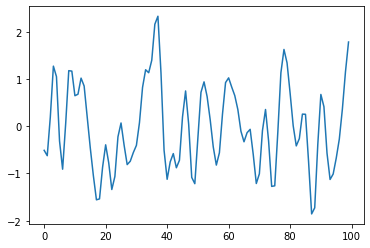

In [2]:
# Have a Look at Region 38, Mouse 0
plt.plot(DataMatrix[37,:100,0])

Text(0, 0.5, 'Amplitude (au)')

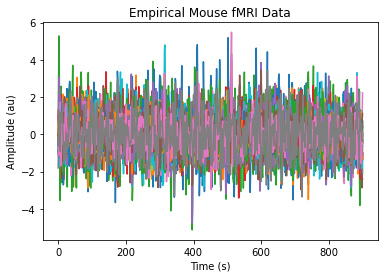

In [3]:
%matplotlib inline
for i in np.arange(38):
    plt.plot(DataMatrix[i,:,0])    

plt.title("Empirical Mouse fMRI Data")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (au)")

In [4]:
# What needs to happen is to obtain each matrix (100 total for the no. of mice)

# Create empty 3D Matrix to hold FC analysis
FCMatrix = np.empty((38,38,100))

for i in range(100):
    # For now we only take the cortical areas, so the first 38 rows.
    run = DataMatrix[0:38,:,i]

    # np.size(DataMatrix[:,:,0]) # Verify correct. 

    # Run Analysis - Pearson Correlation.
    FCM = np.corrcoef(run)
    FCMatrix[:,:,i] = FCM

# Average over the 100 mice. 
FCAverage = FCMatrix.mean(2)

In [5]:
# Write Code to export the simulation to csv.
#np.savetxt("do-not-track\FCM_MouseExperimental.csv", FCAverage, delimiter="\t")

Text(0, 0.5, 'Region')

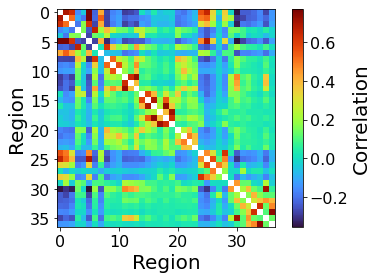

In [6]:
# Plot Matrix
# For Individual slice of FC Matrix: FCMatrix[:,:,0]
np.fill_diagonal(FCAverage,np.nan)

# Remove Frontal Pole
FCAverage = np.delete(FCAverage,obj=7,axis=0)
FCAverage = np.delete(FCAverage,obj=7,axis=1)

# Re-arrange the order to a new order, Ben's Functional Grouping
index_fg = np.array([13,31,10,8,7,9,11,12,0,15,19,25,26,27,34,33,35,29,20,28,16,14,17,18,21,36,4,6,5,32,1,22,30,24,23,3,2])

FCAverage = FCAverage[index_fg] [:,index_fg]

cs=plt.imshow(FCAverage, cmap=ListedColormap(turbo_colormap_data), aspect='equal', interpolation='none')
#plt.title('Functional connectivity matrix', fontsize=20)
axcb=plt.colorbar(cs)
axcb.set_label('Correlation', fontsize=20)
axcb.ax.tick_params(labelsize=16)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.xlabel("Region", fontsize=20)
plt.ylabel("Region", fontsize=20)
#plt.savefig("do-not-track\\FCM_exp.pdf",bbox_inches='tight')

## Calculate Baseline SC-FC 


In [7]:
# Empty dict
ParamsDict = { }
ParamsDict["name"] = "MouseCortex"
#ParamsDict["G"] = np.array([G_value]) 
ParamsDict["REMOVE"] = [7]
ParamsDict["BINARY"]=True

# Load the connectivity data from a zip file. 
con = connectivity.Connectivity.from_file(os.getcwd() +"/Connectomes/" + ParamsDict["name"] + ".zip")

# Remove the ith row and column in centres, tract_lengths and weights. i.e. the specified region(s)
con.centres = np.delete(con.centres,ParamsDict["REMOVE"])
con.weights = np.delete(con.weights,obj=ParamsDict["REMOVE"],axis=0)
con.weights = np.delete(con.weights,obj=ParamsDict["REMOVE"],axis=1)
con.tract_lengths = np.delete(con.tract_lengths,obj=ParamsDict["REMOVE"],axis=0)
con.tract_lengths = np.delete(con.tract_lengths,obj=ParamsDict["REMOVE"],axis=1)

if ParamsDict["BINARY"]==True:
    con.weights = con.weights!=0
SCM = con.weights

) +"/Connectomes/" + ParamsDict["name"] + ".zip")
  File "c:\Users\Pok Him\Desktop\MouseBrainModelling\tvb\datatypes\connectivity.py", line 721, in from_file
    result.orientations = reader.read_optional_array_from_file("average_orientations")
  File "c:\Users\Pok Him\Desktop\MouseBrainModelling\tvb\basic\readers.py", line 202, in read_optional_array_from_file
    return self.read_array_from_file(file_name, dtype, skip_rows, use_cols, matlab_data_name)
  File "c:\Users\Pok Him\Desktop\MouseBrainModelling\tvb\basic\readers.py", line 182, in read_array_from_file
    self.logger.warning("File %r not found in ZIP." % file_name)
Message: "File 'average_orientations' not found in ZIP."
Arguments: ()
--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Pok Him\anaconda3\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "C:\Users\Pok Him\anaconda3\lib\logging\handlers.py", line 394, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\Use

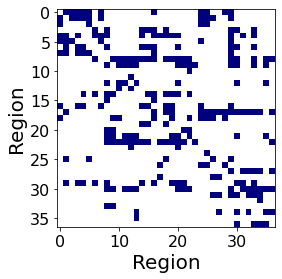

In [8]:
# ListedColormap(turbo_colormap_data)
#matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)
SCM = 1/SCM
# Rearrange SCM
SCM = SCM [index_fg] [:,index_fg]

cs=plt.imshow(SCM, cmap="jet", aspect='equal', interpolation='none')
#plt.title('Structural connectivity matrix', fontsize=20)
#axcb=plt.colorbar(cs)
#axcb.set_label('Weight', fontsize=20)
#plt.yticks([0,1,2,3])
#axcb.ax.tick_params(labelsize=16)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.xlabel("Region", fontsize=20)
plt.ylabel("Region", fontsize=20)
#plt.savefig("do-not-track\\SCM.pdf",bbox_inches='tight')
plt.show()

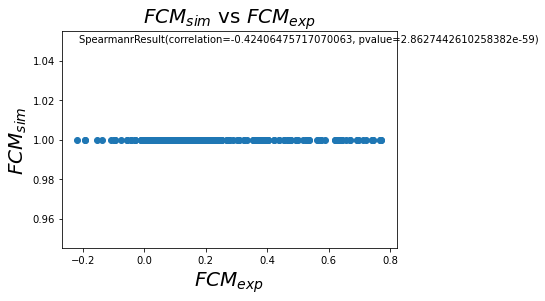

In [9]:
FCM_exp = np.genfromtxt('FCM_MouseExperimental.csv',delimiter = "\t")
# Set diagonals to NaN
np.fill_diagonal(FCM_exp,np.nan)

# Remove the ith row and column in FCM (i.e. the specified region)
FCM_exp = np.delete(FCM_exp,obj=ParamsDict["REMOVE"],axis=0)
FCM_exp = np.delete(FCM_exp,obj=ParamsDict["REMOVE"],axis=1)

np.fill_diagonal(SCM,np.nan)
# Re-arrange
FCM_exp = FCM_exp[index_fg] [:,index_fg]

# Remove all Nans for SCM and FCM
SCM_Upper = SCM[~numpy.isnan(SCM)]
FCM_Upper = FCM_exp[~numpy.isnan(FCM_exp)]


# Spearman Correlation
Scorr = stats.spearmanr(a=FCM_Upper,b=SCM_Upper)
#print(SCorr)

# Scatterplot
plt.scatter(FCM_Upper,SCM_Upper)
plt.xlabel('$FCM_{exp}$', fontsize=20)
plt.ylabel('$FCM_{sim}$', fontsize=20)
plt.title('$FCM_{sim}$ vs $FCM_{exp}$', fontsize=20)
plt.annotate(Scorr, xy=(0.05, 0.95), xycoords='axes fraction')
plt.show()

# Preliminary Look at Cell Atlas for Mouse Brain

Note that this is in the original order, not by functional grouping in the paper.

In [11]:
df = pd.read_csv("CortexDensities.csv",delimiter=",")
E_pop = df.excitatory.values
I_pop = df.inhibitory.values
E_mean = np.mean(E_pop)
I_mean = np.mean(I_pop)

# E_normalised is (when excluding region 7) -0.28 to 0.54
E_normalised = (E_pop-E_mean)/E_mean
# I_normalised is (when excluding region 7) -0.45 to 1.44
I_normalised = (I_pop-I_mean)/I_mean

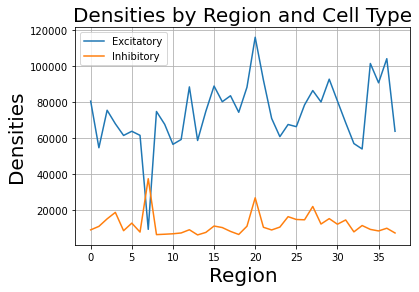

In [12]:
# Graph it: 
plt.plot(E_pop)
plt.plot(I_pop)
plt.xlabel('Region', fontsize=20)
plt.ylabel('Densities', fontsize=20)
plt.title('Densities by Region and Cell Type', fontsize=20)
plt.grid()
plt.legend(("Excitatory","Inhibitory"))
plt.show()


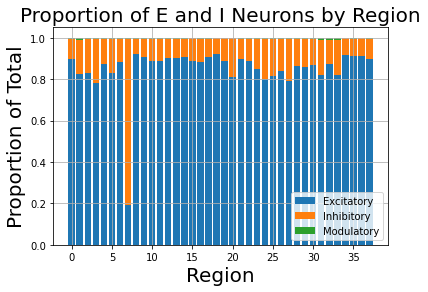

In [13]:
# Graph it: 
fig=plt.figure()
plt.bar(np.arange(38),E_pop/df.neurons)
plt.bar(np.arange(38),I_pop/df.neurons,bottom=E_pop/df.neurons)
plt.bar(np.arange(38),df.modulatory/df.neurons,bottom=E_pop/df.neurons + I_pop/df.neurons)
#plt.plot()
plt.xlabel('Region', fontsize=20)
plt.ylabel('Proportion of Total', fontsize=20)
plt.title('Proportion of E and I Neurons by Region', fontsize=20)
plt.grid()
plt.legend(("Excitatory","Inhibitory","Modulatory"),loc=4)
plt.show()

#fig.savefig('FPC_outlier.pdf', bbox_inches='tight')

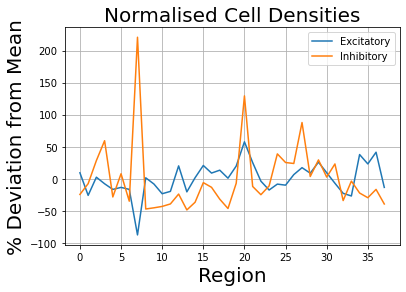

In [14]:
# Graph it: 
plt.plot(E_normalised*100)
plt.plot(I_normalised*100)
plt.xlabel('Region', fontsize=20)
plt.ylabel('% Deviation from Mean', fontsize=20)
plt.title('Normalised Cell Densities', fontsize=20)
plt.grid()
plt.legend(("Excitatory","Inhibitory"))
plt.show()

### Do Same analysis after taking out FPC, Outlier region:

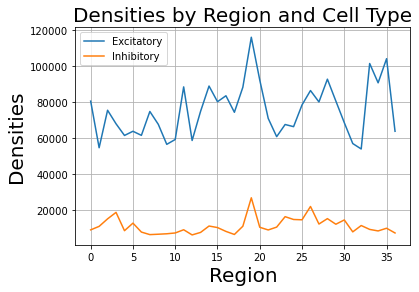

In [15]:
df = pd.read_csv("CortexDensitiesAlter.csv",delimiter=",")
E_pop = df.excitatory.values
I_pop = df.inhibitory.values
E_mean = np.mean(E_pop)
I_mean = np.mean(I_pop)

# E_normalised is (when excluding region 7) -0.28 to 0.54
E_normalised = (E_pop-E_mean)/E_mean
# I_normalised is (when excluding region 7) -0.45 to 1.44
I_normalised = (I_pop-I_mean)/I_mean

# Graph it: 
plt.plot(E_pop)
plt.plot(I_pop)
plt.xlabel('Region', fontsize=20)
plt.ylabel('Densities', fontsize=20)
plt.title('Densities by Region and Cell Type', fontsize=20)
plt.grid()
plt.legend(("Excitatory","Inhibitory"))
plt.show()


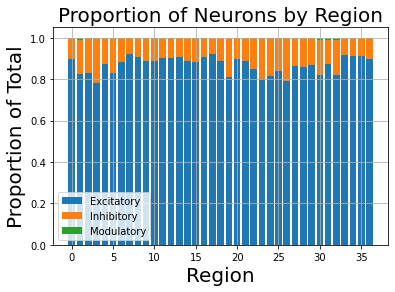

In [16]:
# Graph it: 
plt.bar(np.arange(37),E_pop/df.neurons)
plt.bar(np.arange(37),I_pop/df.neurons,bottom=E_pop/df.neurons)
plt.bar(np.arange(37),df.modulatory/df.neurons,bottom=E_pop/df.neurons + I_pop/df.neurons)
#plt.plot()
plt.xlabel('Region', fontsize=20)
plt.ylabel('Proportion of Total', fontsize=20)
plt.title('Proportion of Neurons by Region', fontsize=20)
plt.grid()
plt.legend(("Excitatory","Inhibitory","Modulatory"))
plt.show()

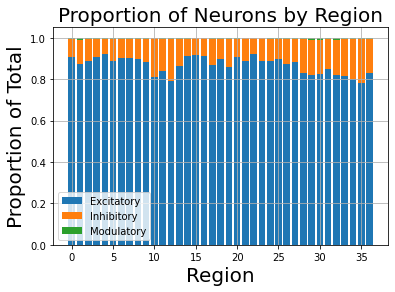

In [23]:
index_fg = np.array([13,31,10,8,7,9,11,12,0,15,19,25,26,27,34,33,35,29,20,28,16,14,17,18,21,36,4,6,5,32,1,22,30,24,23,3,2])
# Graph it: 
plt.bar(np.arange(37),(E_pop/df.neurons)[index_fg])
plt.bar(np.arange(37),(I_pop/df.neurons)[index_fg],bottom=(E_pop/df.neurons)[index_fg])
plt.bar(np.arange(37),(df.modulatory/df.neurons)[index_fg],bottom=(E_pop/df.neurons + I_pop/df.neurons)[index_fg])
#plt.plot()
plt.xlabel('Region', fontsize=20)
plt.ylabel('Proportion of Total', fontsize=20)
plt.title('Proportion of Neurons by Region', fontsize=20)
plt.grid()
plt.legend(("Excitatory","Inhibitory","Modulatory"))
plt.show()

In [17]:
E_prop = E_pop / (E_pop + I_pop)
I_prop = I_pop / (E_pop + I_pop)

Mean_e_prop = np.mean(E_prop)
Mean_i_prop = np.mean(I_prop)

E_prop_norm = (E_prop-Mean_e_prop)/Mean_e_prop
I_prop_norm = (I_prop-Mean_i_prop)/Mean_i_prop

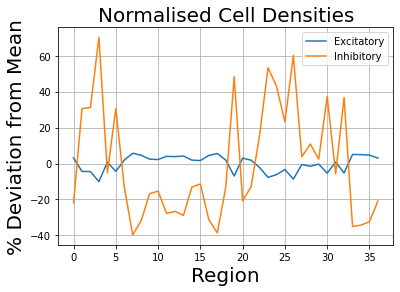

In [18]:
# Graph it: 
plt.plot(E_prop_norm*100)
plt.plot(I_prop_norm*100)
plt.xlabel('Region', fontsize=20)
plt.ylabel('% Deviation from Mean', fontsize=20)
plt.title('Normalised Cell Densities', fontsize=20)
plt.grid()
plt.legend(("Excitatory","Inhibitory"))
plt.show()

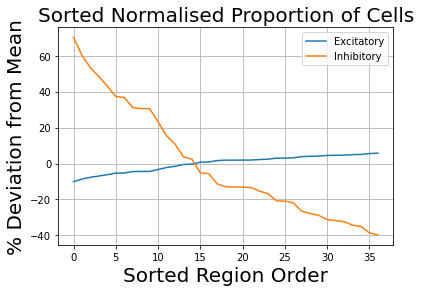

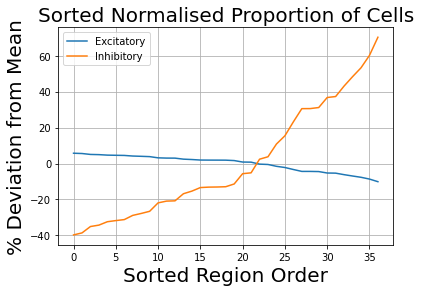

In [19]:
# Graph it: 
Index_e = np.argsort(E_prop_norm)
plt.plot(E_prop_norm[Index_e]*100)
plt.plot(I_prop_norm[Index_e]*100)
plt.xlabel('Sorted Region Order', fontsize=20)
plt.ylabel('% Deviation from Mean', fontsize=20)
plt.title('Sorted Normalised Proportion of Cells', fontsize=20)
plt.grid()
plt.legend(("Excitatory","Inhibitory"))
plt.show()

# Graph it: 
Index_i = np.argsort(I_prop_norm)
plt.plot(E_prop_norm[Index_i]*100)
plt.plot(I_prop_norm[Index_i]*100)
plt.xlabel('Sorted Region Order', fontsize=20)
plt.ylabel('% Deviation from Mean', fontsize=20)
plt.title('Sorted Normalised Proportion of Cells', fontsize=20)
plt.grid()
plt.legend(("Excitatory","Inhibitory"))
plt.show()

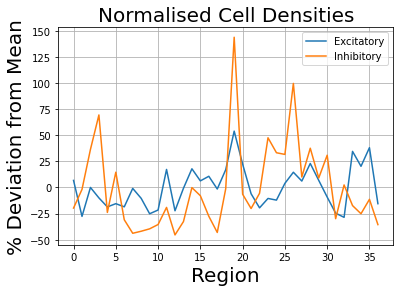

In [20]:
# Graph it: 
plt.plot(E_normalised*100)
plt.plot(I_normalised*100)
plt.xlabel('Region', fontsize=20)
plt.ylabel('% Deviation from Mean', fontsize=20)
plt.title('Normalised Cell Densities', fontsize=20)
plt.grid()
plt.legend(("Excitatory","Inhibitory"))
plt.show()

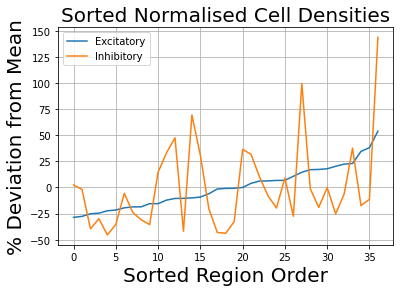

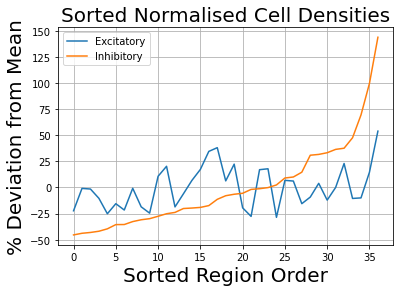

In [21]:
# Graph it: 
Index_e = np.argsort(E_normalised)
Index_i = np.argsort(I_normalised)

plt.plot(E_normalised[Index_e]*100)
plt.plot(I_normalised[Index_e]*100)
plt.xlabel('Sorted Region Order', fontsize=20)
plt.ylabel('% Deviation from Mean', fontsize=20)
plt.title('Sorted Normalised Cell Densities', fontsize=20)
plt.grid()
plt.legend(("Excitatory","Inhibitory"))
plt.show()

plt.plot(E_normalised[Index_i]*100)
plt.plot(I_normalised[Index_i]*100)
plt.xlabel('Sorted Region Order', fontsize=20)
plt.ylabel('% Deviation from Mean', fontsize=20)
plt.title('Sorted Normalised Cell Densities', fontsize=20)
plt.grid()
plt.legend(("Excitatory","Inhibitory"))
plt.show()

## Relation between e:i density and functional grouping

In [211]:
df = pd.read_csv("CortexDensitiesAlter.csv",delimiter=",")
E_pop = df.excitatory.values
I_pop = df.inhibitory.values
E_mean = np.mean(E_pop)
I_mean = np.mean(I_pop)

# E_normalised is (when excluding region 7) -0.28 to 0.54
E_normalised = (E_pop-E_mean)/E_mean
# I_normalised is (when excluding region 7) -0.45 to 1.44
I_normalised = (I_pop-I_mean)/I_mean

index_fg = np.array([13,31,10,8,7,9,11,12,0,15,19,25,26,27,34,33,35,29,20,28,16,14,17,18,21,36,4,6,5,32,1,22,30,24,23,3,2])

E_normalised = E_normalised[index_fg]
I_normalised = I_normalised[index_fg]

Text(0, 0.5, 'e')

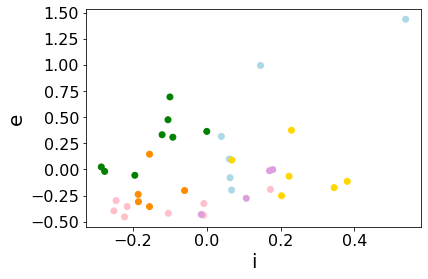

In [212]:
colour_list = ('pink','pink','pink','pink','pink','pink','pink','pink','lightblue','lightblue','lightblue','lightblue','lightblue','lightblue','gold','gold','gold','gold','gold','gold','plum','plum','plum','plum','darkorange','darkorange','darkorange','darkorange','darkorange','green','green','green','green','green','green','green','green')
ground_truth = np.array([0,0,0,0,0,0,0,0,1,1,1,1,1,1,2,2,2,2,2,2,3,3,3,3,4,4,4,4,4,5,5,5,5,5,5,5,5])

plt.scatter(E_normalised,I_normalised,color = colour_list)
#plt.grid()
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("i",fontsize=20)
plt.ylabel("e",fontsize=20)

In [238]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn import *

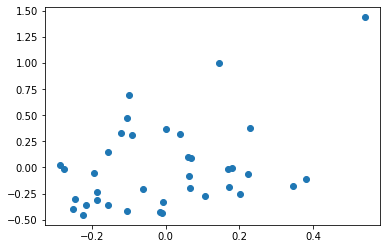

In [239]:
features = np.stack((E_normalised,I_normalised),axis=1)
plt.scatter(features[:,0],features[:,1])

In [240]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [241]:
kmeans = KMeans(init="random",n_clusters=6,n_init=10, max_iter=300, random_state=138)

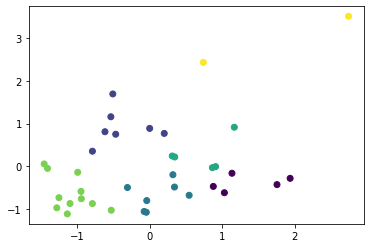

In [242]:
kmeans.fit(scaled_features)
#plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1], color='red')
plt.scatter(scaled_features[:,0],scaled_features[:,1],c =kmeans.labels_)

In [243]:
ari_kmeans = adjusted_rand_score(colour_list, kmeans.labels_)
print(ari_kmeans)
#acc_score = accuracy_score(ground_truth , kmeans.labels_)
#print(acc_score)

0.2167777342218738


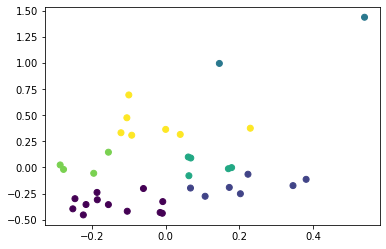

In [247]:
kmeans.fit(features)
#plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1], color='red' ) #c= np.arange(6)
plt.scatter(features[:,0],features[:,1],c =kmeans.labels_,)

In [245]:
ari_kmeans = adjusted_rand_score(colour_list, kmeans.labels_)
print(ari_kmeans)
#acc_score = accuracy_score(ground_truth, kmeans.labels_)
#print(acc_score)

0.3164176254356233


In [278]:
for i in np.arange(50):

    kmeans = KMeans(init="random",n_clusters=6,n_init=10, max_iter=300, random_state=i*12+1)
    kmeans.fit(features)
    ari_kmeans = adjusted_rand_score(colour_list, kmeans.labels_)
    print(ari_kmeans)

0.3164176254356233
0.2979396262577863
0.3164176254356233
0.2979396262577863
0.3164176254356233
0.2183488987664186
0.2522602375465343
0.2979396262577863
0.3164176254356233
0.3164176254356233
0.24191229331416247
0.3164176254356233
0.3164176254356233
0.317518583096265
0.2522602375465343
0.25466574503801714
0.2981540420114577
0.2979396262577863
0.2183488987664186
0.3164176254356233
0.3164176254356233
0.3164176254356233
0.2522602375465343
0.24191229331416247
0.24191229331416247
0.3010007322431047
0.2979396262577863
0.2522602375465343
0.3164176254356233
0.3164176254356233
0.2979396262577863
0.3164176254356233
0.3164176254356233
0.25466574503801714
0.3164176254356233
0.24315652261104986
0.3164176254356233
0.3164176254356233
0.2721311475409836
0.25466574503801714
0.2522602375465343
0.2979396262577863
0.3164176254356233
0.2979396262577863
0.3164176254356233
0.3164176254356233
0.2522602375465343
0.2979396262577863
0.3164176254356233
0.3164176254356233
